In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# CONFIG
batch_size = 128
epochs_clf = 10

In [ ]:
# DATA
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.51MB/s]


In [ ]:
# SAME CLASSIFIER AS PAWAN USED FOR RECONSTRUCTION IMAGES
class InputClassifier(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

clf = InputClassifier().to(device)
optimizer = optim.Adam(clf.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, test_accuracies = [], [], []

In [ ]:
# TRAIN & EVALUATE
for epoch in range(epochs_clf):
    clf.train() # puts the classifier in training mode
    running_loss = 0
    for x,y in train_loader: #Loops through mini batches of (x,y) in the training set
        x,y = x.to(device), y.to(device)
        logits = clf(x) #forward pass...compute model predictions
        loss = criterion(logits, y) # compute loss
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    clf.eval() # switches to evaluation mode
    correct, total, test_loss = 0,0,0
    with torch.no_grad(): # disables gradient computation
        for x,y in test_loader: #loops over test batches
            x,y = x.to(device), y.to(device)
            logits = clf(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            correct += (preds==y).sum().item()
            test_loss += loss.item()
            total += y.size(0)
    avg_test_loss = test_loss / len(test_loader)
    acc = 100*correct/total
    test_losses.append(avg_test_loss)
    test_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs_clf}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Test Loss: {avg_test_loss:.4f} "
          f"Test Accuracy: {acc:.2f}%")

Epoch [1/10] Train Loss: 0.3457 Test Loss: 0.1617 Test Accuracy: 95.04%
Epoch [2/10] Train Loss: 0.1358 Test Loss: 0.1169 Test Accuracy: 96.37%
Epoch [3/10] Train Loss: 0.0899 Test Loss: 0.0882 Test Accuracy: 97.21%
Epoch [4/10] Train Loss: 0.0639 Test Loss: 0.0817 Test Accuracy: 97.39%
Epoch [5/10] Train Loss: 0.0489 Test Loss: 0.0728 Test Accuracy: 97.73%
Epoch [6/10] Train Loss: 0.0368 Test Loss: 0.0737 Test Accuracy: 97.82%
Epoch [7/10] Train Loss: 0.0308 Test Loss: 0.0781 Test Accuracy: 97.82%
Epoch [8/10] Train Loss: 0.0224 Test Loss: 0.0731 Test Accuracy: 97.81%
Epoch [9/10] Train Loss: 0.0204 Test Loss: 0.0812 Test Accuracy: 97.69%
Epoch [10/10] Train Loss: 0.0170 Test Loss: 0.0743 Test Accuracy: 98.05%


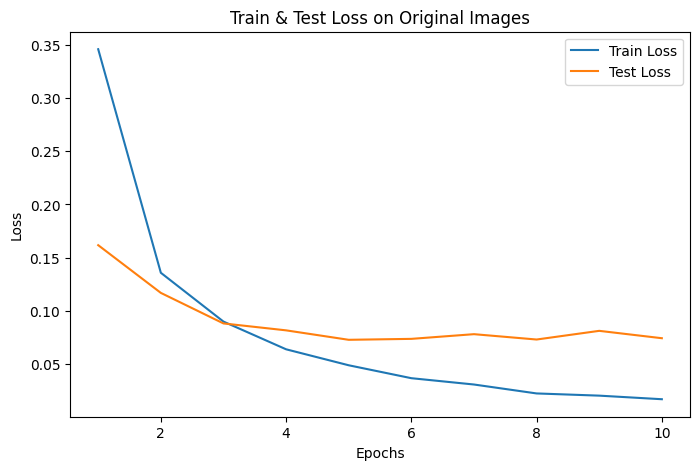

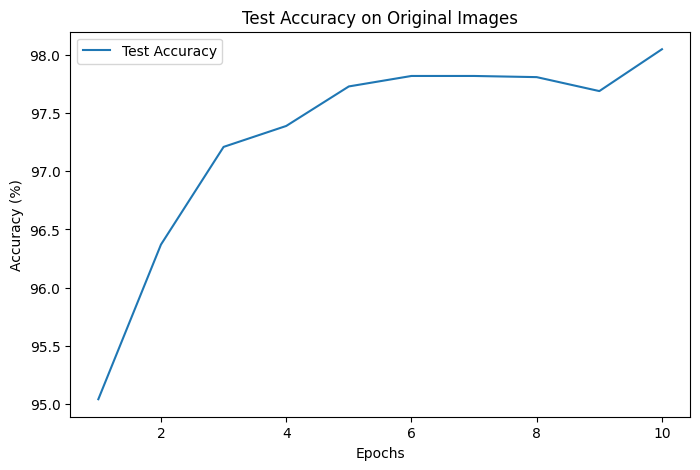


Final Test Accuracy: 98.05%


In [ ]:
# PLOTS
plt.figure(figsize=(8,5))
plt.plot(range(1,epochs_clf+1), train_losses, label='Train Loss')
plt.plot(range(1,epochs_clf+1), test_losses, label='Test Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Train & Test Loss on Original Images")
plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1,epochs_clf+1), test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs"); plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy on Original Images")
plt.legend(); plt.show()

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")